In [1]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from evaluateModel import evaluate_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import chi2, mutual_info_classif, RFE
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
# 1. Obtener un set de datos.
df = pd.read_csv("alzheimers_disease_data.csv")

# 2. Buscar valores vacios
print("Missing values:")
print(df.isna().sum())

# 3. Eliminar columnas que no agrega valor al entrenamiento
df = df.drop('PatientID', axis=1)
df = df.drop('DoctorInCharge', axis=1)

print("\nDistribución original de clases:")
print(df['Diagnosis'].value_counts(normalize=True) * 100)

Missing values:
PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTas

In [3]:
# Guardar las columnas por normalizar
numerical_cols = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "DietQuality", "SleepQuality", "SystolicBP", "DiastolicBP", "CholesterolTotal", "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment", "ADL"]

# Guardar las columnas numéricas
categorical_cols = ["Gender", "Ethnicity", "EducationLevel", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease", "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints", "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks", "Forgetfulness"]

In [4]:
# 4. Separar features y target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [5]:
X_train_val, X_external, y_train_val, y_external = train_test_split(X, y, test_size=0.1, random_state=42)

external_data = pd.concat([X_external, y_external], axis=1)
external_data.to_csv("datos_externos.csv", index=False)

In [6]:
# 5. Dividir en train y test con un split 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [7]:
# 6. Aplicar las técnicas de escalamiento y transformación de datos
# Transformar datos categóricos mediante One Hot Encoder
encoder = OneHotEncoder(sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_cat_encoded = encoder.transform(X_test[categorical_cols])

# Escalamiento de datos numéricos mediante StandarScaler
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_num_scaled = scaler.transform(X_test[numerical_cols])

In [8]:
# 7. Obtener nombres de features
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Crear DataFrames para datos categóricos transformados
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_feature_names)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_feature_names)

# Crear DataFrames para datos numéricos transformados
X_train_num_df = pd.DataFrame(X_train_num_scaled, columns=numerical_cols)
X_test_num_df = pd.DataFrame(X_test_num_scaled, columns=numerical_cols)

In [9]:
# 8. Combinar datos categóricos y numéricos
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

In [10]:
# 9. Transformar target a valor numerico mediante LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
#10. Aplcar data augmentation con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_encoded)

# Implementación de Modelo

### Experimento 1.1

In [12]:
# 11. Entrenar modelos base
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)
nb_model = GaussianNB()
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
lda_model = LinearDiscriminantAnalysis()
ada_boost_model = AdaBoostClassifier(random_state=42)
kNN_model = KNeighborsClassifier(n_neighbors=5)

base_models = [
    ('DT', dt_model),
    ('SVM', svm_model),
    ('NB', nb_model),
    ('LR', lr_model),
    ('RF', rf_model),
    ('LDA', lda_model),
    ('AdaBoost', ada_boost_model),
    ('kNN', kNN_model)
]

      Model  Accuracy  Precision  Sensitivity  Specificity  F1-Score  \
0        DT  0.891473   0.856115     0.843972     0.918699  0.850000   
1       SVM  0.839793   0.772414     0.794326     0.865854  0.783217   
2        NB  0.692506   0.568750     0.645390     0.719512  0.604651   
3        LR  0.824289   0.715976     0.858156     0.804878  0.780645   
4        RF  0.930233   0.919118     0.886525     0.955285  0.902527   
5       LDA  0.813953   0.699422     0.858156     0.788618  0.770701   
6  AdaBoost  0.909561   0.848684     0.914894     0.906504  0.880546   
7       kNN  0.640827   0.504348     0.822695     0.536585  0.625337   

        MCC   AUC-ROC  
0  0.765034  0.881335  
1  0.656368  0.902583  
2  0.356600  0.767947  
3  0.643341  0.903217  
4  0.848564  0.944459  
5  0.626037  0.901978  
6  0.809422  0.943868  
7  0.352125  0.731433  


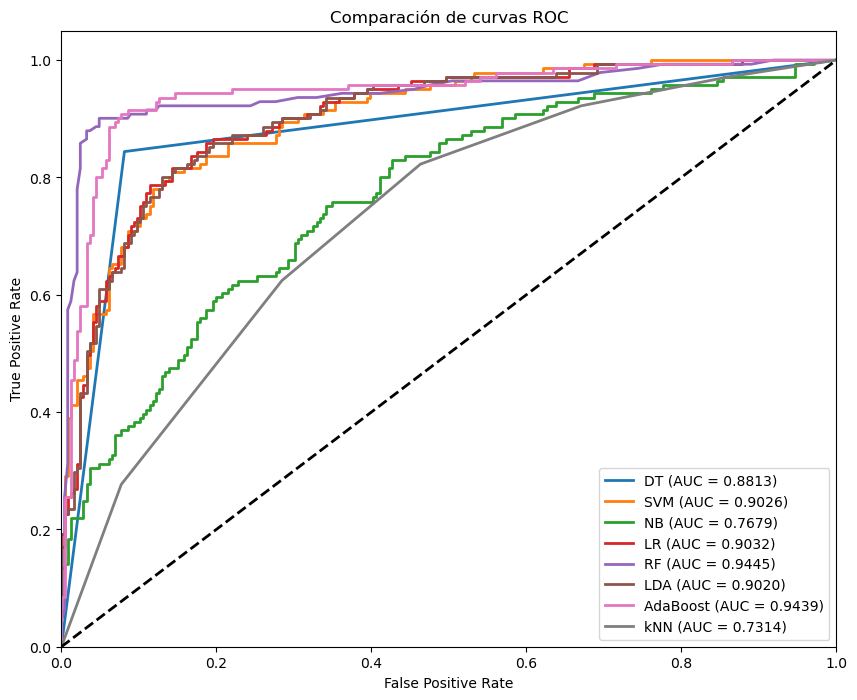

In [13]:
# 12. Obtener resultados de modelos base
base_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Sensitivity': [],
    'Specificity': [],
    'F1-Score': [],
    'MCC': [],
    'AUC-ROC': []
}

roc_curves_base = []

for name, model in base_models:
    model.fit(X_train_resampled, y_train_resampled)
    result = evaluate_model(name, model, X_test_processed, y_test_encoded)
    base_results['Model'].append(name)
    base_results['Accuracy'].append(result['accuracy'])
    base_results['Precision'].append(result['precision'])
    base_results['Sensitivity'].append(result['sensitivity'])
    base_results['Specificity'].append(result['specificity'])
    base_results['F1-Score'].append(result['f1'])
    base_results['MCC'].append(result['mcc'])
    base_results['AUC-ROC'].append(result['auc'])
    if 'fpr' in result:
        roc_curves_base.append(result)

results_df = pd.DataFrame(base_results)
print(results_df)

# Crear gráfico  ROC
plt.figure(figsize=(10, 8))
for curve in roc_curves_base:
    plt.plot(curve['fpr'], curve['tpr'], lw=2, 
             label=f"{curve['name']} (AUC = {curve['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de curvas ROC')
plt.legend(loc="lower right")

### Experimento 1.2

In [14]:
# 13. Selección de características (F-Score)
selector_all = SelectKBest(f_classif, k='all')
selector_all.fit(X_train_resampled, y_train_resampled)
feature_scores = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'F-Score': selector_all.scores_
})
feature_scores = feature_scores.sort_values('F-Score', ascending=False)
print("\nTop características F-Score:")
print(feature_scores.head(15))


Top características F-Score:
                 Feature     F-Score
13  FunctionalAssessment  357.448970
14                   ADL  305.276057
40    MemoryComplaints_1  214.382092
39    MemoryComplaints_0  214.382092
12                  MMSE  159.409317
41  BehavioralProblems_0   74.337197
42  BehavioralProblems_1   74.337197
43           Confusion_0   12.513076
44           Confusion_1   12.513076
5           SleepQuality   10.022251
36          HeadInjury_1    7.546934
35          HeadInjury_0    7.546934
31            Diabetes_0    4.513144
32            Diabetes_1    4.513144
24      EducationLevel_3    4.341399


In [15]:
# 14. Obtención de mejores características (F-Score)
subset_sizes = [2, 4, 6, 7, 8, 9, 10, 12] 

subset_results = {
    'Sub_Fe': [],
    'Accuracy': [],
    'Sensitivity': [],
    'Specificity': [],
    'MCC': []
}

for k in subset_sizes:    
    selector = SelectKBest(f_classif, k=k)
    X_train_k = selector.fit_transform(X_train_resampled, y_train_resampled)
    X_test_k = selector.transform(X_test_processed)
    
    selected_features = X_train_processed.columns[selector.get_support()]
    
    dt_model_k = DecisionTreeClassifier(random_state=42)
    svm_model_k = SVC(probability=True, random_state=42)
    nb_model_k = GaussianNB()
    lr_model_k = LogisticRegression(random_state=42)
    rf_model_k = RandomForestClassifier(random_state=42)
    
    base_models_k = [
        ('DT', dt_model_k),
        ('SVM', svm_model_k),
        ('NB', nb_model_k),
        ('LR', lr_model_k),
        ('RF', rf_model_k)
    ]
    
    # Crear modelo propuesta mezclada 
    voting_model_k = VotingClassifier(estimators=base_models_k, voting='hard')
    voting_model_k.fit(X_train_k, y_train_resampled)
    
    # Evaluar modelo 
    result = evaluate_model('Ensemble', voting_model_k, X_test_k, y_test_encoded)
    
    subset_results['Sub_Fe'].append(k)
    subset_results['Accuracy'].append(result['accuracy'])
    subset_results['Sensitivity'].append(result['sensitivity'])
    subset_results['Specificity'].append(result['specificity'])
    subset_results['MCC'].append(result['mcc'])


In [16]:
# 15. Obtener resultados experimento 1.1
subset_results_df = pd.DataFrame(subset_results)
print(subset_results_df)

   Sub_Fe  Accuracy  Sensitivity  Specificity       MCC
0       2  0.754522     0.595745     0.845528  0.457069
1       4  0.798450     0.751773     0.825203  0.570629
2       6  0.919897     0.914894     0.922764  0.829495
3       7  0.914729     0.907801     0.918699  0.818447
4       8  0.914729     0.907801     0.918699  0.818447
5       9  0.914729     0.907801     0.918699  0.818447
6      10  0.912145     0.914894     0.910569  0.814386
7      12  0.919897     0.914894     0.922764  0.829495


In [17]:
# 16. Identificar  mejor subconjunto
best_subset_idx = subset_results_df['Accuracy'].idxmax()
best_k = subset_results_df.loc[best_subset_idx, 'Sub_Fe']
print(f"\nMejor subconjunto: {best_k} características")
print(f"Accuracy: {subset_results_df.loc[best_subset_idx, 'Accuracy']:.2f}%")


Mejor subconjunto: 6 características
Accuracy: 0.92%


In [18]:
# 17. Seleccionar mejor subconjunto
final_selector = SelectKBest(f_classif, k=int(best_k))
X_train_selected = final_selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = final_selector.transform(X_test_processed)

### Experimento 2.1

In [19]:
# 18. Crear modelos para integración final
dt_model_final = DecisionTreeClassifier(random_state=42)
svm_model_final = SVC(probability=True, random_state=42)
nb_model_final = GaussianNB()
lr_model_final = LogisticRegression(random_state=42)
rf_model_final = RandomForestClassifier(random_state=42)

base_models_final = [
    ('DT', dt_model_final),
    ('SVM', svm_model_final),
    ('NB', nb_model_final),
    ('LR', lr_model_final),
    ('RF', rf_model_final)
]

In [20]:
# 18. Crear modelo final y validar como indica el paper
voting_model_final = VotingClassifier(estimators=base_models_final, voting='hard')

# Configurar la validación cruzada como indica el paper
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
}

cv_results = cross_validate(voting_model_final, X_train_selected, y_train_resampled, cv=kfold, scoring=scoring, return_estimator=True)

print(f"Accuracy: {cv_results['test_accuracy'].mean()*100:.2f}%")
print(f"Precision: {cv_results['test_precision'].mean()*100:.2f}%")
print(f"Sensitivity: {cv_results['test_recall'].mean()*100:.2f}%")
print(f"F1-Score: {cv_results['test_f1'].mean()*100:.2f}%")


Accuracy: 93.41%
Precision: 94.10%
Sensitivity: 92.63%
F1-Score: 93.34%


In [21]:
# 19. Evaliuación modelo final
voting_model_final.fit(X_train_selected, y_train_resampled)
final_result = evaluate_model('Ensemble Final', voting_model_final, X_test_selected, y_test_encoded)

print(f"Accuracy: {final_result['accuracy']:.4f}")
print(f"Precision: {final_result['precision']:.4f}")
print(f"Sensitivity: {final_result['sensitivity']:.4f}")
print(f"Specificity: {final_result['specificity']:.4f}")
print(f"F1-Score: {final_result['f1']:.4f}")
print(f"MCC: {final_result['mcc']:.4f}")

Accuracy: 0.9199
Precision: 0.8716
Sensitivity: 0.9149
Specificity: 0.9228
F1-Score: 0.8927
MCC: 0.8295


### Experimento 2.2

In [22]:
# 20. Resultados y preparación de vlaidación de features
fs_results = {
    'Método': [],
    'Accuracy': []
}

kfold_10 = KFold(n_splits=10, shuffle=True, random_state=42)

best_k = X_train_selected.shape[1]

In [23]:
# 21. Evaluación F-Score
fs_results['Método'].append('F-Score')
fs_results['Accuracy'].append(cv_results['test_accuracy'].mean() * 100)

In [24]:
# 21. Evaluación Chi-Square
X_min = X_train_resampled.min(axis=0)
X_pos = X_train_resampled - X_min + 0.001 

chi2_selector = SelectKBest(chi2, k=best_k)
X_chi2 = chi2_selector.fit_transform(X_pos, y_train_resampled)
chi2_accuracy = cross_val_score(voting_model_final, X_chi2, y_train_resampled, 
                               cv=kfold_10, scoring='accuracy').mean() * 100
fs_results['Método'].append('Chi-Square')
fs_results['Accuracy'].append(chi2_accuracy)

In [25]:
# 22. Evaluación Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=best_k)
X_mi = mi_selector.fit_transform(X_train_resampled, y_train_resampled)
mi_accuracy = cross_val_score(voting_model_final, X_mi, y_train_resampled, 
                             cv=kfold_10, scoring='accuracy').mean() * 100
fs_results['Método'].append('MutInfo')
fs_results['Accuracy'].append(mi_accuracy)


In [26]:
# 23. Evaluación RFE
estimator = LogisticRegression(max_iter=1000, random_state=42)
rfe_selector = RFE(estimator, n_features_to_select=best_k)
X_rfe = rfe_selector.fit_transform(X_train_resampled, y_train_resampled)
rfe_accuracy = cross_val_score(voting_model_final, X_rfe, y_train_resampled, 
                              cv=kfold_10, scoring='accuracy').mean() * 100
fs_results['Método'].append('RFE')
fs_results['Accuracy'].append(rfe_accuracy)


In [27]:
# 24. Evaluación Lasso
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_train_resampled, y_train_resampled)

coefs = np.abs(lasso.coef_[0])

feature_names = X_train_resampled.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefs
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_features = feature_importance.head(best_k)['Feature'].values

X_lasso = X_train_resampled.loc[:, top_features]

lasso_accuracy = cross_val_score(voting_model_final, X_lasso, y_train_resampled,  cv=kfold_10, scoring='accuracy').mean() * 100
fs_results['Método'].append('Lasso')
fs_results['Accuracy'].append(lasso_accuracy)

In [28]:
fs_df = pd.DataFrame(fs_results)
print(fs_df)

       Método   Accuracy
0     F-Score  93.407606
1  Chi-Square  92.857960
2     MutInfo  87.264179
3         RFE  87.513184
4       Lasso  93.406716


# Refinamiento del modelo

In [29]:
# 25. Crear parametros para los modelos
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20]
}

svm_params = {
    'C': [0.1, 1, 2.14355, 10],
    'kernel': ['linear', 'rbf']
}

nb_params = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]
}

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2', None]
}

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [3, 5]
}

In [30]:
# 26. Función para refinar un modelo deseado
def refine_model(model, param_grid, X_train, y_train):
    model.fit(X_train, y_train)
    
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    refined_model = grid.best_estimator_
    
    return refined_model

In [31]:
# 27. Función para refinar todos los modelos
def refine_all(X_train, y_train):
    dt = refine_model(
        DecisionTreeClassifier(random_state=42), 
        dt_params, X_train, y_train)
    
    svm = refine_model(
        SVC(probability=True, random_state=42), 
        svm_params, X_train, y_train)
    
    nb = refine_model(
        GaussianNB(), 
        nb_params, X_train, y_train)
    
    lr = refine_model(
        LogisticRegression(random_state=42, max_iter=1000), 
        lr_params, X_train, y_train)
    
    rf = refine_model(
        RandomForestClassifier(random_state=42), 
        rf_params, X_train, y_train)
    
    return {
        'DT': dt,
        'SVM': svm,
        'NB': nb,
        'LR': lr,
        'RF': rf
    }

In [32]:
# 28 Obtención de modelos refinados
refined_models = refine_all(X_train_selected, y_train_resampled)

base_models_final_refined = [
    ('DT', refined_models['DT']),
    ('SVM', refined_models['SVM']),
    ('NB', refined_models['NB']),
    ('LR', refined_models['LR']),
    ('RF', refined_models['RF'])
]

/Users/sebastianflores/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sebastianflores/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sebastianflores/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sebastianflores/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sebastianflores/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sebastianflor

In [33]:
# 29. Crear modelo final con sub modelos optimizados
voting_model_final_refined = VotingClassifier(estimators=base_models_final_refined, voting='hard')

# Configurar la validación cruzada como indica el paper
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
}

cv_results = cross_validate(voting_model_final_refined, X_train_selected, y_train_resampled, cv=kfold, scoring=scoring, return_estimator=True)

print(f"Accuracy: {cv_results['test_accuracy'].mean()*100:.2f}%")
print(f"Precision: {cv_results['test_precision'].mean()*100:.2f}%")
print(f"Sensitivity: {cv_results['test_recall'].mean()*100:.2f}%")
print(f"F1-Score: {cv_results['test_f1'].mean()*100:.2f}%")


Accuracy: 94.01%
Precision: 95.35%
Sensitivity: 92.54%
F1-Score: 93.90%


In [34]:
# 30. Evaliuación modelo final refinado
voting_model_final_refined.fit(X_train_selected, y_train_resampled)
final_result = evaluate_model('Ensemble Final', voting_model_final_refined, X_test_selected, y_test_encoded)

print(f"Accuracy: {final_result['accuracy']:.4f}")
print(f"Precision: {final_result['precision']:.4f}")
print(f"Sensitivity: {final_result['sensitivity']:.4f}")
print(f"Specificity: {final_result['specificity']:.4f}")
print(f"F1-Score: {final_result['f1']:.4f}")
print(f"MCC: {final_result['mcc']:.4f}")

Accuracy: 0.9380
Precision: 0.9149
Sensitivity: 0.9149
Specificity: 0.9512
F1-Score: 0.9149
MCC: 0.8661


# Guardar el Modelo

In [35]:
components = {
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'selector': final_selector,
    'selected_features': selected_features,
    'model': voting_model_final_refined,
}

with open('modelo_alzheimer.pkl', 'wb') as f:
    pickle.dump(components, f)